In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import keras
from tqdm import tqdm
import plotly.express as px

c:\Users\jigna\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Heat Equation:

\begin{align}
\partial_t u_{\theta}(t,x,y) + \partial^2_{xx}u_{\theta}(t,x,y)+\partial^2_{yy}u_{\theta}(t,x,y) 
&= 0\\
u_{\theta}(0,x,y) &= -1\\
u_{\theta}(t,x,0) = u_{\theta}(t,0,y) = u_{\theta}(t,1,y) &= -1\\
u_{\theta}(t,x,1) &=1
\end{align}

Here time-space is modeled by $(t,x,y)\in[0,1]^{3}$, thus $u_{\theta}\colon[0,1]^3\to \R$


In [3]:
class HeatModel(tf.Module):
    # Heat equation PINN-solver. 
    def __init__(self, layers_size):

        self.layers = layers_size
        # List of tf.Tensor objects
        self.W = []

        # Initializer
        init = tf.initializers.GlorotUniform(seed=333)

        for i in range(len(layers_size) - 1):
            input_dim = layers_size[i]
            output_dim = layers_size[i + 1]

            w = tf.Variable(init([output_dim, input_dim], dtype='float64'), trainable=True, name=f'w{i+1}')
            b = tf.zeros([output_dim, 1], dtype='float64')
            b = tf.Variable(b, trainable=True, name=f'b{i+1}')

            self.W.append(w)
            self.W.append(b)

        # Learning rate
        self.learning_rate = 0.0001
    
    

    def evaluate(self, x):
        """Evaluates the NN at x.

        Args:
            x : Shape must match the NN input shape.

        Returns:
            tf.Tensor: u_theta(x)
        """
        a = x
        for i in range(len(self.layers) - 2):
            z = tf.add(tf.matmul(self.W[2*i], a), self.W[2*i + 1])
            a = tf.nn.tanh(z)

        a = tf.add(tf.matmul(self.W[-2], a), self.W[-1])
        return a
    
    def set_weights(self, new_weights):
        # Setter for the parameters.
        # Shapes must coincide.
        for i in range(len(new_weights)):
            self.W[i].assign(new_weights[i])
        self.get_weights() 

   
    ##################### LOSS METHODS ###########################

    def initial_condition_loss(self, init_data):
        return tf.add(self.evaluate(init_data), 1)
        
    def upper_boundary_loss(self, up_boundary_data):
        return tf.add(self.evaluate(up_boundary_data), -1)
    
    def lower_boundary_loss(self, lower_boundary_data):
        return tf.add(self.evaluate(lower_boundary_data), 1)
        
    def left_boundary_loss(self, left_boundary_data):
        return tf.add(self.evaluate(left_boundary_data), 1)
    
    def right_boundary_loss(self, right_boundary_data):
        return tf.add(self.evaluate(right_boundary_data), 1)

    def physics_loss(self, interior_data):

        # Error given by the PDE over data_set.
        # We compute the first and second derivative w.r.t the NN variable.
        # returns tf.Tensor shape=().
        # Every derivative is reshaped to shape (1,1).
        
        z = tf.reshape(tf.Variable(interior_data, trainable=False), (3,1))
        with tf.GradientTape() as tape2:
            with tf.GradientTape() as tape1:
                tape1.watch(z)
                u = self.evaluate(z)
            u_z = tape1.gradient(u, z)
            tape2.watch(z)
        u_zz = tape2.gradient(u_z, z)

        u_t = tf.reshape(u_z[0], (1,1))
        u_xx = tf.reshape(u_zz[1], (1,1))
        u_yy = tf.reshape(u_zz[2], (1,1))

        del tape1, tape2
        
        return tf.subtract(u_t, tf.add(u_xx, u_yy))


    def total_loss(self, init_data, up_boundary_data, lower_boundary_data, left_boundary_data, right_boundary_data, interior_data):
        # Loss computed from the PDE + loss from training data.
        # returns: tf.Tensor shape=()

        return tf.square(self.initial_condition_loss(init_data)\
                          + self.upper_boundary_loss(up_boundary_data)\
                          + self.lower_boundary_loss(lower_boundary_data)\
                          + self.left_boundary_loss(left_boundary_data)\
                          + self.right_boundary_loss(right_boundary_data)\
                          + self.physics_loss(interior_data))

    ##################### TRAINING METHODS ###########################

    def gradients(self, boundary_data, init_data, int_data):
        # This function computes the gradient of total_loss() method
        # w.r.t trainable_variables.
        # Returns gradients evaluated at the current data point and
        # trainable variable, also returns the current value of the
        # loss function.
        # Since self.trainable_variables is constantly being updated,
        # the gradient is evaluated at different values of weights.

        with tf.GradientTape() as tape:
            tape.watch(self.trainable_variables)
            target = self.total_loss(boundary_data, init_data, int_data)
        gradients = tape.gradient(target, self.trainable_variables)
        return gradients, target

    def apply_gradients(self, gradients_list: list):
        """Updates the parameters according to SGD iteration.

        Args:
            gradients_list (list): list of tf.Tensor
        """
        for g, p in zip(gradients_list, self.W):
            p.assign_sub(self.learning_rate * g)
    
    
    def train(self, num_iter, len_data_set):
        opt = tf.keras.optimizers.Adam(learning_rate=5e-4)
        
        boundary_data, init_data, int_data = self.generate_data_sets(len_data_set, 1)

        l = []
        for _ in tqdm(range(num_iter)):
            i = np.random.randint(len_data_set)
            g, val = self.gradients(boundary_data[i], init_data[i], int_data[i])
            opt.apply_gradients(zip(g, self.trainable_variables))
            l.append(val)
        return l

            

In [4]:
# Create model with input dimension 3 (t,x,y) and output dimension 1.

model = HeatModel([3,20,20,20,20,20,1])

# data
n = 500
init_data = [[[0],[x],[y]] for x,y in zip(np.random.uniform(0,1,n), np.random.uniform(0,1,n))]
up_boundary_data = [[[t],[x],[1]] for t,x in zip(np.random.uniform(0,1,n), np.random.uniform(0,1,n))]
lower_boundary_data = [[[t],[x],[0]] for t,x in zip(np.random.uniform(0,1,n), np.random.uniform(0,1,n))]
left_boundary_data = [[[t],[0],[y]] for t,y in zip(np.random.uniform(0,1,n), np.random.uniform(0,1,n))]
right_boundary_data = [[[t],[1],[y]] for t,y in zip(np.random.uniform(0,1,n), np.random.uniform(0,1,n))]
interior_data = [[[t],[x],[y]] for t,x,y in zip(np.random.uniform(0,1,n), np.random.uniform(0,1,n), np.random.uniform(0,1,n))]



100%|██████████| 500/500 [00:18<00:00, 26.38it/s]


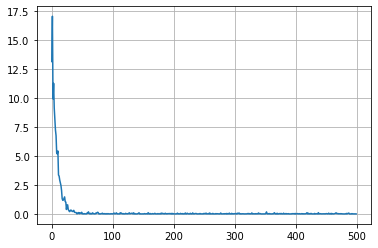

In [5]:
old = model.W
np.random.seed(11111)
num_iter = 500
gradients_list = []
val = []
thetas = []
for i in tqdm(range(num_iter)):
    j1 = np.random.randint(n)
    j2 = np.random.randint(n)
    j3 = np.random.randint(n)
    j4 = np.random.randint(n)
    j5 = np.random.randint(n)
    j6 = np.random.randint(n)
    with tf.GradientTape() as tape:
        tape.watch(model.W)
        target = model.initial_condition_loss(init_data[j1])
        target = model.total_loss(init_data[j1],\
                                 up_boundary_data[j2],\
                                  lower_boundary_data[j3],\
                                  left_boundary_data[j4],\
                                  right_boundary_data[j5],\
                                 interior_data[j6])
        
    grads = tape.gradient(target, model.W)
    model.apply_gradients(grads)

    val.append(target)
    gradients_list.append(grads)

values = list(map(lambda v: v[0][0].numpy(), val))
plt.plot(values)
plt.grid()

